In [61]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import time

In [35]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [36]:
set_seed()

In [37]:
 transform = transforms.Compose([transforms.ToTensor()])

In [38]:
train_set = ImageFolder(root='cinic10/versions/1/train//', transform=transform)
validate_set = ImageFolder(root='cinic10/versions/1/valid//', transform=transform)
test_set = ImageFolder(root='cinic10/versions/1/test//', transform=transform)

In [39]:
train_set.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [40]:
img, label  = train_set[0]

In [41]:
img



tensor([[[0.8588, 0.8588, 0.8627,  ..., 0.8510, 0.8471, 0.8392],
         [0.8667, 0.8667, 0.8745,  ..., 0.8588, 0.8549, 0.8471],
         [0.8667, 0.8667, 0.8745,  ..., 0.8588, 0.8549, 0.8471],
         ...,
         [0.8980, 0.9020, 0.9098,  ..., 0.8980, 0.8902, 0.8863],
         [0.8471, 0.8549, 0.8706,  ..., 0.8980, 0.8902, 0.8824],
         [0.7608, 0.7490, 0.7725,  ..., 0.8980, 0.8902, 0.8824]],

        [[0.9333, 0.9333, 0.9373,  ..., 0.9176, 0.9137, 0.9059],
         [0.9412, 0.9412, 0.9490,  ..., 0.9294, 0.9216, 0.9137],
         [0.9412, 0.9412, 0.9490,  ..., 0.9255, 0.9216, 0.9137],
         ...,
         [0.9608, 0.9569, 0.9569,  ..., 0.9412, 0.9412, 0.9412],
         [0.9020, 0.9098, 0.9255,  ..., 0.9412, 0.9412, 0.9373],
         [0.8157, 0.8039, 0.8275,  ..., 0.9412, 0.9412, 0.9373]],

        [[0.9608, 0.9608, 0.9647,  ..., 0.9490, 0.9412, 0.9412],
         [0.9686, 0.9686, 0.9765,  ..., 0.9608, 0.9529, 0.9490],
         [0.9686, 0.9686, 0.9765,  ..., 0.9569, 0.9529, 0.

In [42]:
class_names = train_set.classes
num_labels = len(class_names)

In [43]:
data_loader = DataLoader(train_set, batch_size=64, num_workers=8, generator=torch.Generator(device='cpu'),pin_memory=True, shuffle=True,persistent_workers=True, prefetch_factor=4)
data_loader_val = DataLoader(validate_set, batch_size=64, num_workers=8, generator=torch.Generator(device='cpu'),pin_memory=True, shuffle=True,persistent_workers=True, prefetch_factor=4)
data_loader_test = DataLoader(test_set, batch_size=64, num_workers=4, generator=torch.Generator(device='cpu'),persistent_workers=True)


# ResNet
The first model we try is ResNet. It is suitable for 256x256 pictures, so we change initial parameteres a bit, so 16x16 pictures can be suitable as well. What is more, the most popular set it has been trained on is ImageNet-1K. We have only 10 labels we want to assess, then we have to change the size of the last layer as well

In [44]:
from torchvision.models import resnext50_32x4d 

In [45]:
model = resnext50_32x4d()

In [46]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [47]:
model.fc = nn.Linear(2048, num_labels, bias = True)
model.conv1 = nn.Conv2d(3,64, kernel_size = (3,3), stride = 1, padding = 1, bias = False)

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 30
for epoch in range(num_epochs): 
    print('Entered the loop')
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for i, (batch_X, batch_Y) in enumerate(data_loader):
        X = batch_X.to(device, non_blocking=True)  
        if(i == 1):
            print('going')
        Y = batch_Y.to(device, non_blocking=True)  
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == Y).sum().item()
        total += Y.size(0)
    
        #if(i%100==99):
        #    current_time = time.time()
        #    elapsed_time = current_time - previous_time
        #    previous_time = current_time
        #    print(f"Epoch {epoch + 1}, i: {i}, Loss: {total_loss / (i+1)}")
        #    print(f"Number: {i}, Time elapsed: {elapsed_time:.2f}")
    # Obliczenie średniego straty na epokę
    avg_loss = total_loss / len(data_loader)
    train_accuracy = correct / total * 100
    train_losses.append(avg_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_Y in data_loader_val:
            X = batch_X.to(device, non_blocking=True)
            Y = batch_Y.to(device, non_blocking=True)
            outputs = model(X)
            loss = criterion(outputs, Y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == Y).sum().item()
            total += Y.size(0)
    avg_val_loss = val_loss / len(data_loader_val)
    val_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
    
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)




Entered the loop
going
Epoch 1, Average Loss: 1.5744
Epoch 1, Validation Loss: 1.3500, Accuracy: 50.31%
Entered the loop
going
Epoch 2, Average Loss: 1.1944
Epoch 2, Validation Loss: 1.3206, Accuracy: 55.49%
Entered the loop
going
Epoch 3, Average Loss: 1.0211
Epoch 3, Validation Loss: 1.1610, Accuracy: 58.73%
Entered the loop
going
Epoch 4, Average Loss: 0.9028
Epoch 4, Validation Loss: 0.9320, Accuracy: 66.59%
Entered the loop
going
Epoch 5, Average Loss: 0.8029
Epoch 5, Validation Loss: 1.0555, Accuracy: 63.82%
Entered the loop
going
Epoch 6, Average Loss: 0.7073
Epoch 6, Validation Loss: 0.8802, Accuracy: 69.18%
Entered the loop
going
Epoch 7, Average Loss: 0.6150
Epoch 7, Validation Loss: 0.8244, Accuracy: 71.93%
Entered the loop
going
Epoch 8, Average Loss: 0.5130
Epoch 8, Validation Loss: 0.9455, Accuracy: 68.85%
Entered the loop
going
Epoch 9, Average Loss: 0.4207
Epoch 9, Validation Loss: 0.9218, Accuracy: 70.44%
Entered the loop
going
Epoch 10, Average Loss: 0.3351
Epoch 10, 

KeyboardInterrupt: 

In [58]:
model.eval()
test_loss = 0
correct = 0
total = 0

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in data_loader_test:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)  
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())  
        all_predictions.extend(predicted.cpu().numpy())

avg_test_loss = test_loss / len(data_loader_test)
test_accuracy = 100 * correct / total

conf_matrix = confusion_matrix(all_labels, all_predictions)

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)



Test Loss: 1.3774
Test Accuracy: 70.08%
Confusion Matrix:
[[6512  244  387  127  201  135   86  201  875  232]
 [  69 7207   58  121   82   64  115   71  291  922]
 [ 293   33 5865  761  618  486  564   98  256   26]
 [  37   45  474 5881  628 1056  617  137   91   34]
 [  60   26  485  860 6156  706  213  346  115   33]
 [  30   69  515 1974 1040 4510  319  365  130   48]
 [  19   11  417  684  182  156 7438   25   56   12]
 [  39   97  217  399 1100  631   64 6238  129   86]
 [ 276  278  253  173  204  133  134   83 7249  217]
 [ 104 1834   80  163  149  121   73  129  328 6019]]


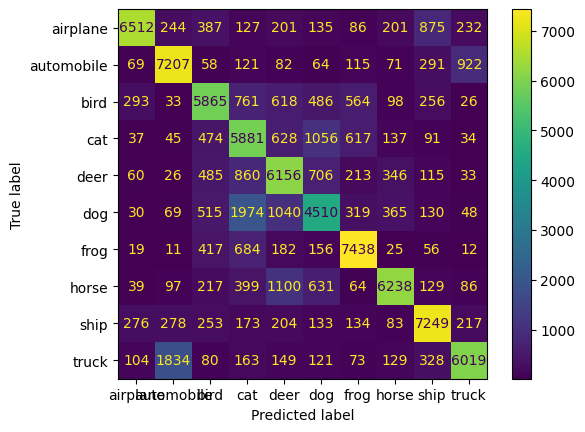

In [62]:
from sklearn import metrics

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = train_set.classes)
cm_display.plot()
plt.show() 

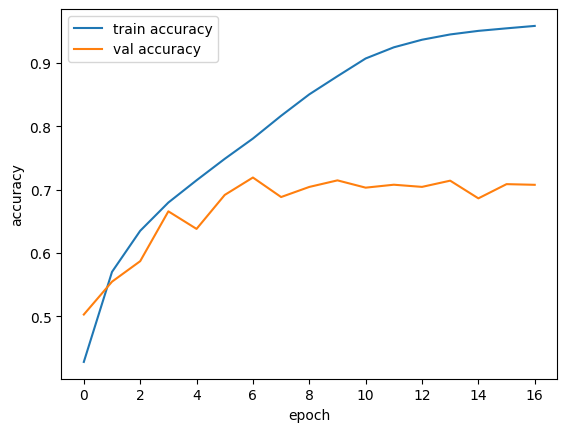

In [90]:
plt.plot(list(map(lambda x: x / 100, train_accuracies)), label = 'train accuracy')
plt.plot(list(map(lambda x: x / 100, val_accuracies)), label = 'val accuracy')

plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.legend()
plt.show()



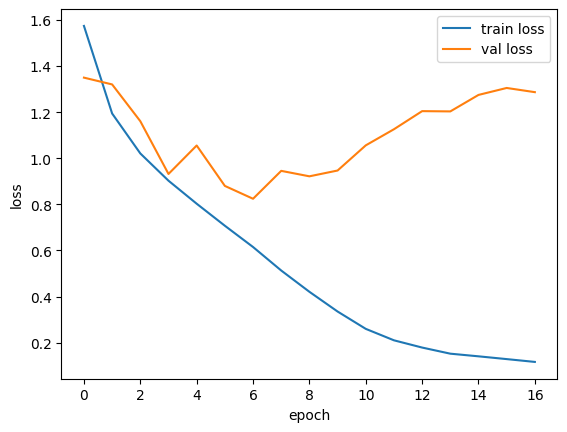

In [91]:
plt.plot(train_losses, label = 'train loss')
plt.plot(val_losses, label = 'val loss')

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend()
plt.show()

# EfficientNet

In [92]:
from torchvision.models import efficientnet_b0

In [122]:
model1 = efficientnet_b0()

In [123]:
print(model1)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [124]:
#model1.features[0][0] =  nn.Conv2d(3,64, kernel_size = (4,4), stride = 1, padding = 1, bias = False)

In [125]:
model1.classifier[1] = nn.Linear(in_features=1280, out_features=num_labels, bias=True)

In [126]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.to(device)

optimizer = torch.optim.AdamW(model1.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 30
for epoch in range(num_epochs): 
    print('Entered the loop')
    model1.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for i, (batch_X, batch_Y) in enumerate(data_loader):
        X = batch_X.to(device, non_blocking=True)  
        if(i == 1):
            print('going')
        Y = batch_Y.to(device, non_blocking=True)  
        optimizer.zero_grad()
        outputs = model1(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == Y).sum().item()
        total += Y.size(0)
    
        #if(i%100==99):
        #    current_time = time.time()
        #    elapsed_time = current_time - previous_time
        #    previous_time = current_time
        #    print(f"Epoch {epoch + 1}, i: {i}, Loss: {total_loss / (i+1)}")
        #    print(f"Number: {i}, Time elapsed: {elapsed_time:.2f}")
    # Obliczenie średniego straty na epokę
    avg_loss = total_loss / len(data_loader)
    train_accuracy = correct / total * 100
    train_losses.append(avg_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")

    model1.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_Y in data_loader_val:
            X = batch_X.to(device, non_blocking=True)
            Y = batch_Y.to(device, non_blocking=True)
            outputs = model1(X)
            loss = criterion(outputs, Y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == Y).sum().item()
            total += Y.size(0)
    avg_val_loss = val_loss / len(data_loader_val)
    val_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
    
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)






Entered the loop
going
Epoch 1, Average Loss: 1.8338
Epoch 1, Validation Loss: 1.6965, Accuracy: 37.39%
Entered the loop
going
Epoch 2, Average Loss: 1.5348
Epoch 2, Validation Loss: 1.4329, Accuracy: 46.78%
Entered the loop
going
Epoch 3, Average Loss: 1.4404
Epoch 3, Validation Loss: 1.3642, Accuracy: 50.77%
Entered the loop
going
Epoch 4, Average Loss: 1.3303
Epoch 4, Validation Loss: 1.3175, Accuracy: 52.64%
Entered the loop
going
Epoch 5, Average Loss: 1.2956
Epoch 5, Validation Loss: 1.2946, Accuracy: 53.39%
Entered the loop
going
Epoch 6, Average Loss: 1.2919
Epoch 6, Validation Loss: 1.2577, Accuracy: 54.76%
Entered the loop
going
Epoch 7, Average Loss: 1.1785
Epoch 7, Validation Loss: 1.2018, Accuracy: 56.99%
Entered the loop
going
Epoch 8, Average Loss: 1.1318
Epoch 8, Validation Loss: 1.2559, Accuracy: 54.78%
Entered the loop
going
Epoch 9, Average Loss: 1.1541
Epoch 9, Validation Loss: 1.1502, Accuracy: 58.86%
Entered the loop
going
Epoch 10, Average Loss: 1.2733
Epoch 10, 

In [127]:
model1.eval()
test_loss = 0
correct = 0
total = 0

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in data_loader_test:
        images, labels = images.to(device), labels.to(device)

        outputs = model1(images)
        loss = criterion(outputs, labels)  
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())  
        all_predictions.extend(predicted.cpu().numpy())

avg_test_loss = test_loss / len(data_loader_test)
test_accuracy = 100 * correct / total

conf_matrix = confusion_matrix(all_labels, all_predictions)

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)



Test Loss: 1.0434
Test Accuracy: 62.87%
Confusion Matrix:
[[6558  193  424  182  145   70   59  210  874  285]
 [ 323 6223   71  133   51  137   67  140  549 1306]
 [ 494   39 5292  650  850  595  580  189  285   26]
 [  56   49  631 4623  922 1629  681  200  134   75]
 [ 192   32  583  766 5380  604  296  899  173   75]
 [  89   59  561 1940 1187 4021  245  673  128   97]
 [  30   39  795  972  310  165 6576   23   69   21]
 [ 147   53  204  436  819  818   41 6213   98  171]
 [1029  271  300  237  226  165   92  130 6056  494]
 [ 323 1807   51  191   91  165   42  218  474 5638]]


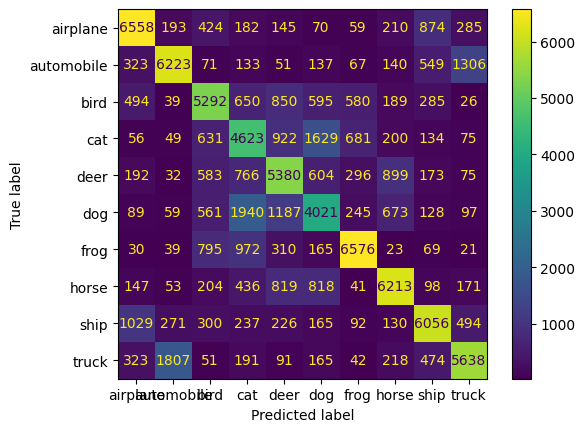

In [128]:
from sklearn import metrics

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = train_set.classes)
cm_display.plot()
plt.show() 

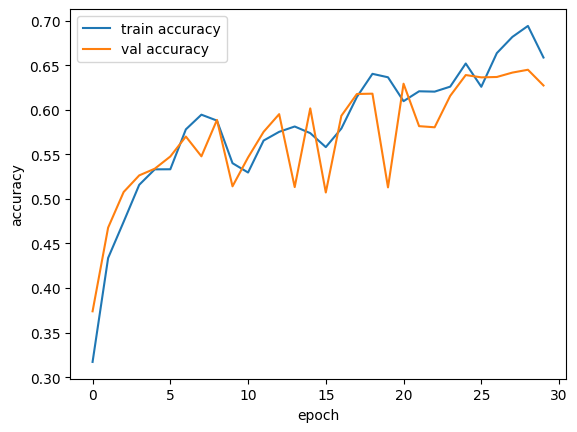

In [129]:
plt.plot(list(map(lambda x: x / 100, train_accuracies)), label = 'train accuracy')
plt.plot(list(map(lambda x: x / 100, val_accuracies)), label = 'val accuracy')

plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.legend()
plt.show()



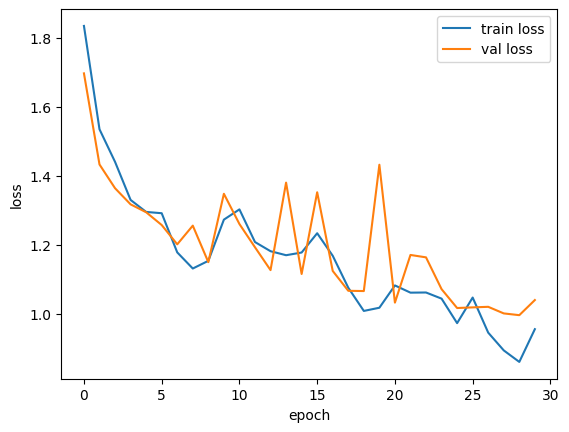

In [130]:
plt.plot(train_losses, label = 'train loss')
plt.plot(val_losses, label = 'val loss')

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend()
plt.show()